In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf
import pickle
import statsmodels.stats.multitest
import sklearn.utils
from matplotlib.patches import Patch
from tqdm import tqdm

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)

from utils import transform, plot, stats
from modeling.check_fit import *

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 16, "font.family": "Asana Math", "figure.dpi": 192})
thcolor = "#44546A"

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Load optimal simulations, demographics and other data needed:

In [5]:
itMax = 81
lmbda = 210
params = {
    "G": "0.5-4",
    "wee": "0.05-0.75",
    "wei": "0.05-0.75",
    "wie": "0",
}
het_params = "wee-wei"
n_vols_remove = 13  # ~ 30s: int(30 / 2.2)

elig_subs = pd.read_csv(
    os.path.join(INPUT_DIR, "imagen_subs_FU2.csv"), index_col=0
).sort_index()
parcels = transform.load_ordered_parcel_labels("schaefer-100")

In [6]:
if os.path.exists("imagen_fc-ses_sc-FU2_runs-2.csv") & os.path.exists(
    "imagen_fc-ses_sc-FU2_runs-2_vars.pkz"
):
    subjects_optima = pd.read_csv("imagen_fc-ses_sc-FU2_runs-2.csv", index_col=0)
    with open("imagen_fc-ses_sc-FU2_runs-2_vars.pkz", "rb") as f:
        regional_vars = pickle.load(f)
else:
    subjects_optima = []
    regional_vars = {}
    for sub in tqdm(elig_subs.index):
        regional_vars[sub] = {}
        for ses in ["BL", "FU2"]:
            cmaes_dir = os.path.join(
                OUTPUT_DIR["imagen"],
                ses,
                "sim",
                sub,
                "sc-FU2_ctx_parc-schaefer-100_mean001_thresh-1",
                "6maps_schaefer-100_zscore",
                "cmaes_multimaps_gpu",
            )
            sims_dir = cmaes_dir.replace("cmaes_multimaps_gpu", "sims_multimaps_gpu")
            sc_path = os.path.join(
                OUTPUT_DIR["imagen"],
                "FU2",
                "SC",
                sub,
                "ctx_parc-schaefer-100_mean001_thresh-1_desc-strength.txt",
            )
            maps_path = os.path.join(INPUT_DIR, "6maps_schaefer-100_zscore.txt")
            emp_fc_tril_path = os.path.join(
                OUTPUT_DIR["imagen"],
                ses,
                "FC",
                sub,
                "ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass-none_exc-inter_desc-FCtril.txt",
            )
            emp_fcd_tril_path = emp_fc_tril_path.replace("FCtril", "FCDtril")
            emp_fc_tril = np.loadtxt(emp_fc_tril_path)
            emp_fcd_tril = np.loadtxt(emp_fcd_tril_path)
            regional_vars[sub][ses] = {}
            for SeedMW in [1, 2]:
                cmaes_res = load_cmaes(
                    cmaes_dir,
                    sims_dir,
                    params,
                    het_params,
                    maps_path,
                    emp_fc_tril,
                    emp_fcd_tril,
                    sc_path=sc_path,
                    n_vols_remove=n_vols_remove,
                    itMax=itMax,
                    lmbda=lmbda,
                    SeedMW=SeedMW,
                    dataset="imagen",
                )
                if cmaes_res:
                    cmaes_res[0]["sub"] = sub
                    cmaes_res[0]["ses"] = ses
                    cmaes_res[0]["SeedMW"] = SeedMW
                    subjects_optima.append(cmaes_res[0])
                    regional_vars[sub][ses][SeedMW] = cmaes_res[1]
    subjects_optima = pd.DataFrame(subjects_optima)
    subjects_optima.to_csv("imagen_fc-ses_sc-FU2_runs-2.csv")
    with open("imagen_fc-ses_sc-FU2_runs-2_vars.pkz", "wb") as f:
        pickle.dump(regional_vars, f)

Select the best run in each subject-session and add the demographics and motion measures to the data:

In [7]:
subjects_optima[["sex", "site"]] = elig_subs.loc[
    subjects_optima.set_index("sub").index, ["sex", "recruitment centre"]
].values
best_runs = subjects_optima.groupby(["sub", "ses"])["gof"].idxmax().values
data = subjects_optima.loc[best_runs]
data.loc[data["ses"] == "BL", "age"] = elig_subs.loc[
    data.loc[data["ses"] == "BL", "sub"].values, "age_BL"
].values
data.loc[data["ses"] == "FU2", "age"] = elig_subs.loc[
    data.loc[data["ses"] == "FU2", "sub"].values, "age_FU2"
].values
data = data.set_index(["sub", "ses"])

# add motion data
motion_BL = pd.read_csv(
    os.path.join(OUTPUT_DIR["imagen"], "BL", "postfmriprep", "participants.tsv"),
    delimiter="\t",
)
motion_BL["ses"] = "BL"
motion_FU2 = pd.read_csv(
    os.path.join(OUTPUT_DIR["imagen"], "FU2", "postfmriprep", "participants.tsv"),
    delimiter="\t",
)
motion_FU2["ses"] = "FU2"
motion = pd.concat([motion_BL, motion_FU2]).rename(columns={"participant_label": "sub"})
motion = motion.set_index(["sub", "ses"]).loc[data.index]
data = pd.concat([data, motion], axis=1)

Create a dataframe of regional $\langle I^E \rangle$ in each subject

In [8]:
I_E = pd.DataFrame(index=data.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for idx, row in data.iterrows():
        sub = idx[0]
        ses = idx[1]
        I_E.loc[idx, parc] = regional_vars[sub][ses][row["SeedMW"]].loc[i, "I_E"]

# Figure 3. Longitudinal effect of age on the excitation-inhibition balance during adolescence

Apply the linear mixed effects model:

In [9]:
df = pd.concat([I_E, data], axis=1)
df.columns = [f"node_{i}" for i in range(100)] + list(df.columns[100:])

t_age = pd.Series(index=parcels)
d_age = pd.Series(index=parcels)
p_age = pd.Series(index=parcels)

for i, parc in tqdm(enumerate(parcels)):
    # exclude outliers
    curr_subs_BL = (
        I_E.loc[(slice(None), ["BL"]), parc]
        .loc[~(scipy.stats.zscore(I_E.loc[(slice(None), ["BL"]), parc]).abs() >= 3)]
        .index.get_level_values(0)
    )
    curr_subs_FU2 = (
        I_E.loc[(slice(None), ["FU2"]), parc]
        .loc[~(scipy.stats.zscore(I_E.loc[(slice(None), ["FU2"]), parc]).abs() >= 3)]
        .index.get_level_values(0)
    )
    curr_subs = curr_subs_BL.intersection(curr_subs_FU2)
    model_df = df.loc[(curr_subs, slice(None))].reset_index(drop=False)
    # calculate standardized mean difference of I_E resid as a variant of Cohen's d
    res_conf = smf.mixedlm(
        f"node_{i} ~ gof + sex + mean_rms + site", data=model_df, groups=model_df["sub"]
    ).fit()
    model_df["resid"] = res_conf.resid
    resid_diff = (
        model_df.loc[model_df["ses"] == "FU2", "resid"].values
        - model_df.loc[model_df["ses"] == "BL", "resid"].values
    )
    d_age.loc[parc] = resid_diff.mean() / resid_diff.std(ddof=1)
    # fit the main model
    mod = smf.mixedlm(
        f"node_{i} ~ age + gof + sex + mean_rms + site",
        data=model_df,
        groups=model_df["sub"],
    )
    res = mod.fit()
    t_age.loc[parc] = res.tvalues["age"]
    p_age.loc[parc] = res.pvalues["age"]

# FDR correction
_, p_age_fdr = statsmodels.stats.multitest.fdrcorrection(p_age)
p_age_fdr = pd.Series(p_age_fdr, index=parcels)

# display stats of signficant regions
stats_age = pd.DataFrame({"t": t_age, "d": d_age, "p": p_age, "p_fdr": p_age_fdr})
stats_age[stats_age["p_fdr"] < 0.05].sort_values(by="t").round(3)

100it [00:30,  3.27it/s]


,t,d,p,p_fdr
7Networks_LH_Cont_pCun_1,-3.981,-0.298,0.000,0.005
7Networks_LH_Vis_1,-3.784,-0.299,0.000,0.005
7Networks_LH_Cont_Par_1,-3.758,-0.272,0.000,0.005
7Networks_LH_DorsAttn_Post_5,-3.695,-0.290,0.000,0.005
7Networks_RH_DorsAttn_Post_3,-3.677,-0.284,0.000,0.005
7Networks_LH_SalVentAttn_Med_2,-3.591,-0.264,0.000,0.005
7Networks_RH_DorsAttn_Post_1,-3.548,-0.272,0.000,0.005
7Networks_LH_Default_pCunPCC_2,-3.544,-0.265,0.000,0.005
7Networks_RH_Cont_Par_1,-3.521,-0.267,0.000,0.005
7Networks_LH_DorsAttn_Post_3,-3.475,-0.260,0.001,0.005


In [11]:
stats_age.to_csv("p_imagen_fc-ses_sc-FU2_runs-2_IE_age_stats.csv")

## a. Effect of age on $\langle I_i^E \rangle$ (FDR-corrected)

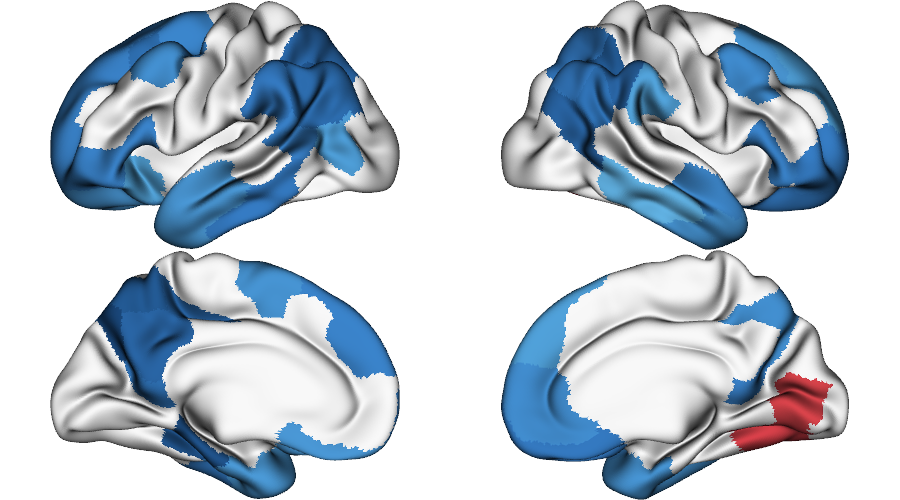

In [10]:
plot.plot_surface(
    transform.deparcellate_surf(
        t_age[p_age_fdr < 0.05], "schaefer-100", concat=True, space="fsaverage"
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu_r",
    cbar=False,
    layout_style="grid",
)

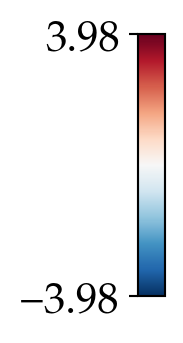

In [12]:
vmin = min(t_age.values.min(), -t_age.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), "RdBu_r", figsize=(2, 2));

## b. Effect of age on $\langle I_i^E \rangle$ (unthresholded)

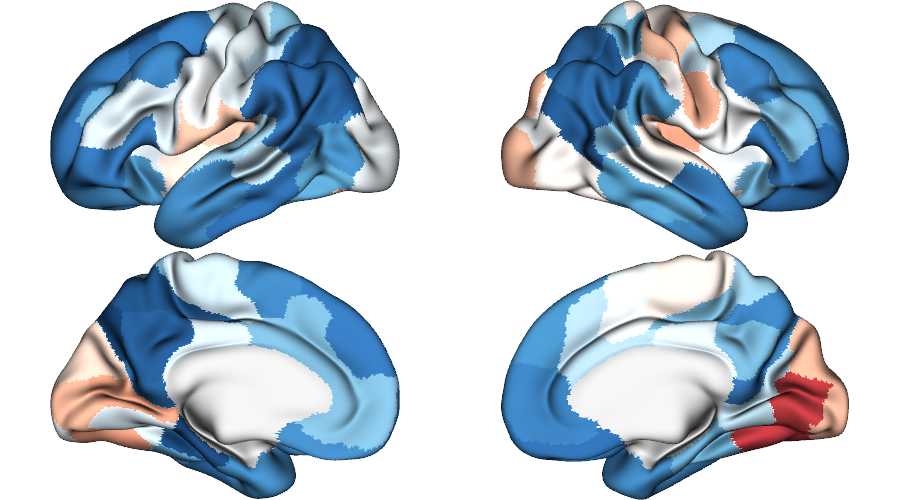

In [13]:
plot.plot_surface(
    transform.deparcellate_surf(t_age, "schaefer-100", concat=True, space="fsaverage"),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu_r",
    cbar=False,
    layout_style="grid",
)

## c. Stability of age effect map across subsamples of subjects

Calculate age effects in 100 half-split subsamples of subjects:

In [40]:
n_subsamples = 100
n_samples = elig_subs.shape[0] // 2
print("Using n_samples", n_samples)

t_subsamples = pd.DataFrame(index=parcels, columns=range(n_subsamples), dtype=float)
p_subsamples = pd.DataFrame(index=parcels, columns=range(n_subsamples), dtype=float)

for subsample in tqdm(range(n_subsamples)):
    # creating half-split subsamples without replacement
    # stratified by sex and site
    # using subsample index as random_state for reproducibility
    subsample_subs = sklearn.utils.resample(
        elig_subs,
        replace=False,
        n_samples=n_samples,
        random_state=subsample,
        stratify=elig_subs[["sex", "recruitment centre"]],
    )
    subsample_df = df.loc[(subsample_subs.index, slice(None))]
    for i, parc in enumerate(parcels):
        # exclude outliers
        curr_subs = subsample_subs.loc[
            ~(scipy.stats.zscore(subsample_df.loc[:, f"node_{i}"]).abs() >= 3)
            .reset_index()
            .groupby("sub")[f"node_{i}"]
            .any()
        ].index
        model_df = subsample_df.loc[(curr_subs, slice(None))].reset_index(drop=False)
        # fit the model
        mod = smf.mixedlm(
            f"node_{i} ~ age + gof + sex + mean_rms + site",
            data=model_df,
            groups=model_df["sub"],
        )
        res = mod.fit()
        t_subsamples.loc[parc, subsample] = res.tvalues["age"]
        p_subsamples.loc[parc, subsample] = res.pvalues["age"]

Using n_samples 74


100%|█████████████████████████████████████████████████████████████| 100/100 [15:16<00:00,  9.17s/it]


Calculate spatial correlation of $\langle I_i^E \rangle$ age effects between all pairs of subsamples:

In [43]:
subsamples_corr = np.corrcoef(t_subsamples.values.T)
subsamples_corr = subsamples_corr[np.tril_indices_from(subsamples_corr, -1)]

Plot the distribution of correlations:

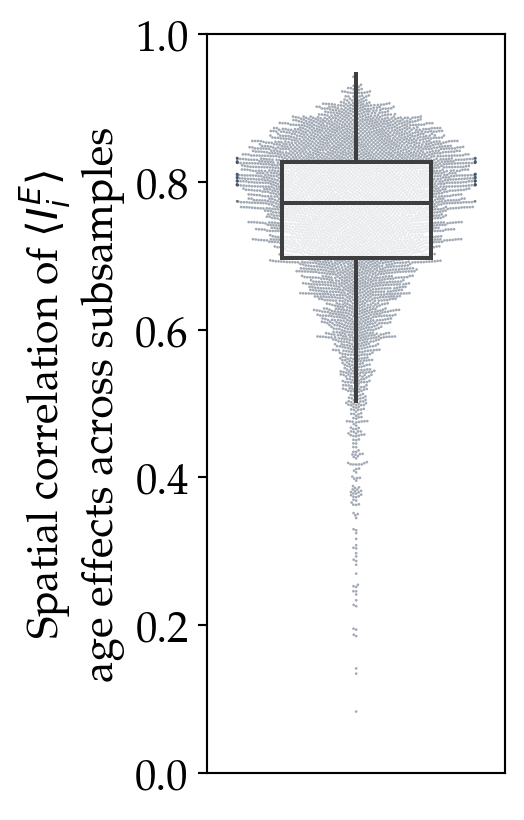

In [44]:
fig, ax = plt.subplots(figsize=(2, 5))
sns.swarmplot(y=subsamples_corr, color=thcolor, s=1, alpha=0.5, ax=ax)
sns.boxplot(
    data=subsamples_corr,
    showfliers=False,
    showcaps=False,
    width=0.5,
    boxprops={"facecolor": (1, 1, 1, 0.75)},
    ax=ax,
)
plt.setp(ax.collections, zorder=0, label="")  # puts swarm in the back
ax.set_ylabel(
    r"Spatial correlation of $\langle I_i^E \rangle$" "\nage effects across subsamples"
)
ax.set_ylim([0, 1])
ax.set_xticks([]);

In [45]:
pd.Series(subsamples_corr).describe()

count    4950.000000
mean        0.749599
std         0.107783
min        -0.012969
25%         0.696859
50%         0.770886
75%         0.826283
max         0.945709
dtype: float64

## d. Conjunction of significant regions from PNC and IMAGEN

In [14]:
stats_age_pnc = pd.read_csv("p_pnc_fc-sub_sc-sub_runs-2_IE_age_stats.csv", index_col=0)
stats_age_imagen = stats_age

conj = (stats_age_pnc["p_fdr"] < 0.05) & (stats_age_imagen["p_fdr"] < 0.05)
conj_t = pd.DataFrame({"pnc": stats_age_pnc["t"], "imagen": stats_age_imagen["t"]}).loc[
    conj
]
conj_t.describe()

,pnc,imagen
count,33.000000,33.000000
mean,-4.466251,-3.175966
std,1.333693,0.361488
min,-7.329795,-3.981309
25%,-5.143936,-3.420748
50%,-4.458318,-3.169074
75%,-3.272985,-2.936594
max,-2.370438,-2.532283


Conjunction does not include increases, therefore let's plot the conjunction parcels as a mask of blues:

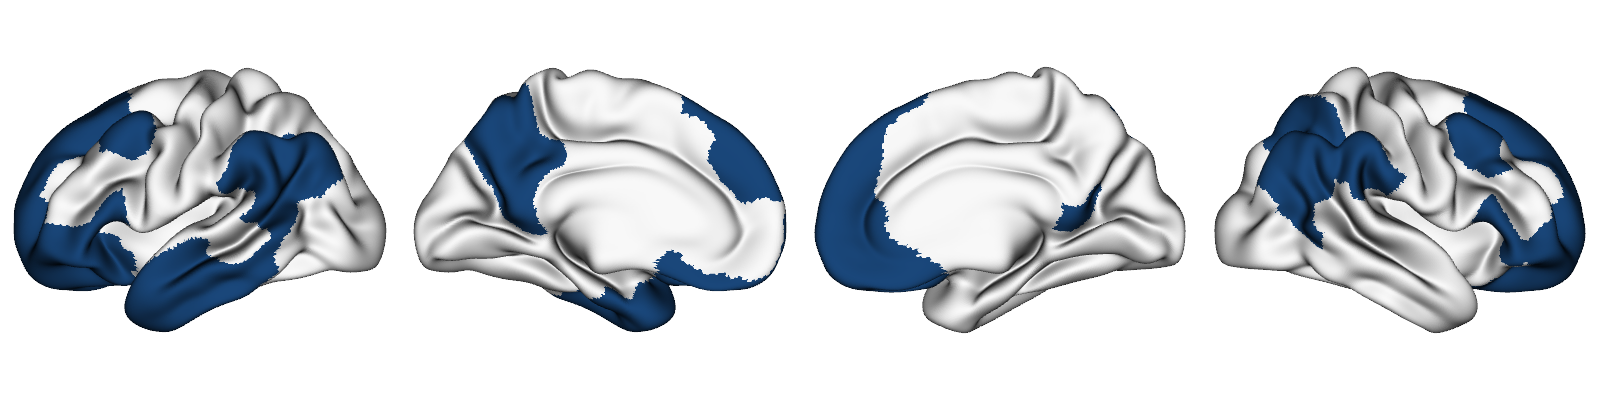

In [27]:
plot.plot_surface(
    transform.deparcellate_surf(
        (conj_t.iloc[:, 0] < 0).astype("int"),
        "schaefer-100",
        concat=True,
        space="fsaverage",
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu",
    cbar=False,
    layout_style="row",
)

## e. Correlation with PNC age effects

In [9]:
r_aget_pnc, p_aget_pnc, _ = stats.spin_test_parcellated(
    stats_age_pnc[["t"]], stats_age_imagen[["t"]], "schaefer-100", n_perm=1000
)
print("Correlation coefficients\n", r_aget_pnc, "\nSpin p-values\n", p_aget_pnc)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficients
           t
t  0.629836 
Spin p-values
      t
t  0.0


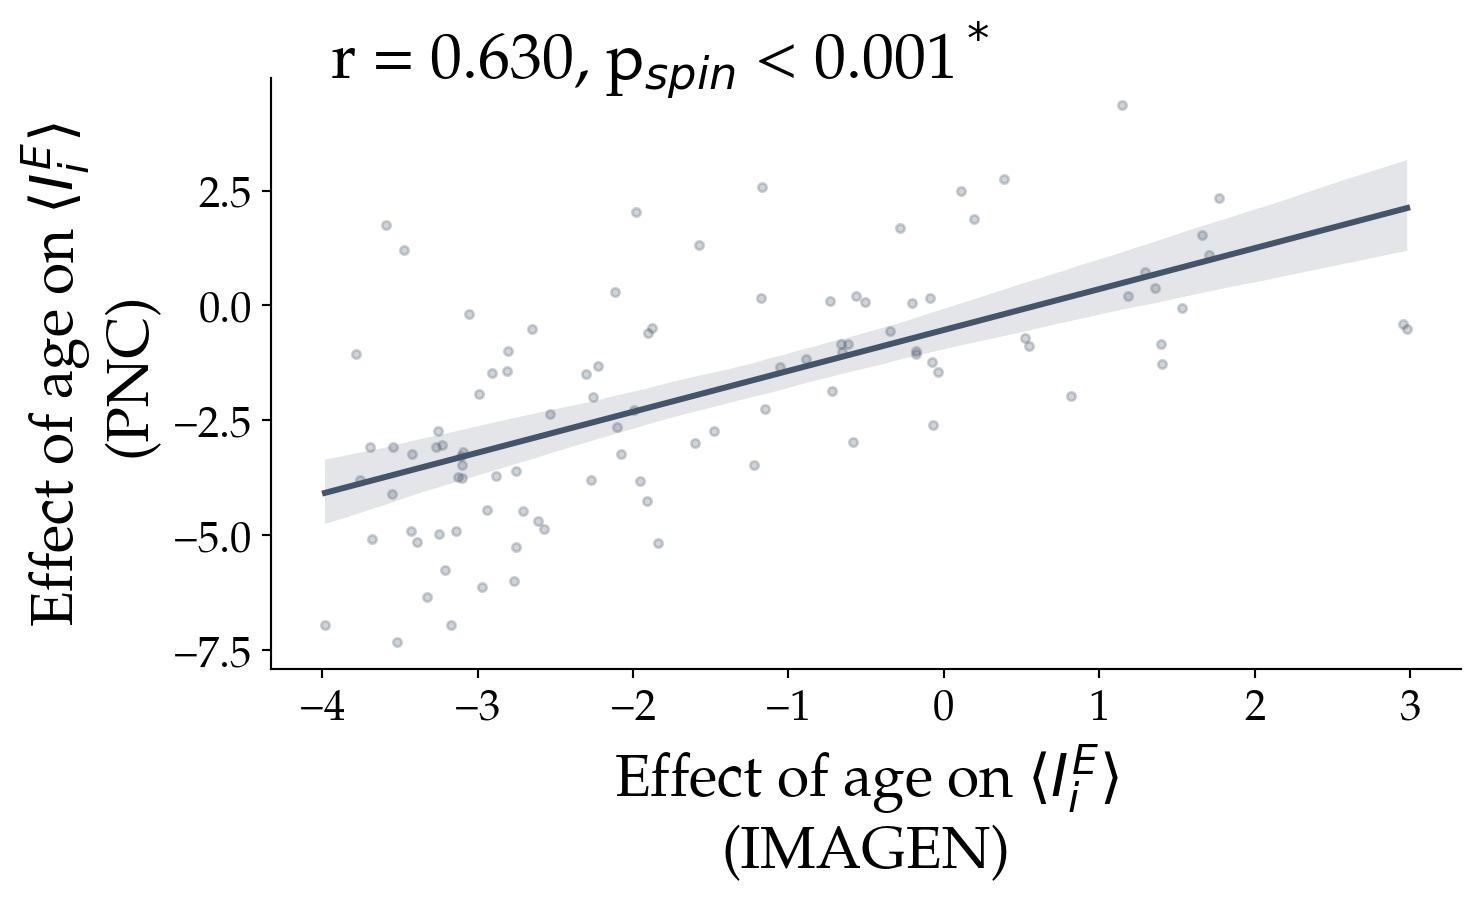

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.regplot(
    x=stats_age_imagen["t"],
    y=stats_age_pnc["t"],
    scatter_kws=dict(color=thcolor, alpha=0.25, s=10),
    line_kws=dict(color=thcolor),
    ax=ax,
)
r = r_aget_pnc.values[0, 0]
p = p_aget_pnc.values[0, 0]
if p > 0.001:
    text = f"r = {r:.3f}, p = {p:.3f}"
else:
    text = f"r = {r:.3f}, p < 0.001"
if p < 0.05:
    text += r"$^*$"
text = text.replace("p", r"p$_{spin}$")
text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 1
ax.text(text_x, text_y, text, color="black", size=24, multialignment="left")
ax.set_xlabel(
    r"Effect of age on $\langle I_i^E \rangle$" "\n(IMAGEN)",
    fontdict=dict(fontsize=22),
)
ax.set_ylabel(
    r"Effect of age on $\langle I_i^E \rangle$" "\n(PNC)",
    fontdict=dict(fontsize=22),
)
sns.despine()

## Text. Age-by-sex intercation

In [8]:
t_age_sex = pd.Series(index=parcels, dtype=float)
p_age_sex = pd.Series(index=parcels, dtype=float)
for i, parc in enumerate(parcels):
    # exclude outliers
    curr_subs_BL = (
        I_E.loc[(slice(None), ["BL"]), parc]
        .loc[~(scipy.stats.zscore(I_E.loc[(slice(None), ["BL"]), parc]).abs() >= 3)]
        .index.get_level_values(0)
    )
    curr_subs_FU2 = (
        I_E.loc[(slice(None), ["FU2"]), parc]
        .loc[~(scipy.stats.zscore(I_E.loc[(slice(None), ["FU2"]), parc]).abs() >= 3)]
        .index.get_level_values(0)
    )
    curr_subs = curr_subs_BL.intersection(curr_subs_FU2)
    model_df = df.loc[(curr_subs, slice(None))].reset_index(drop=False)
    mod = smf.ols(f"node_{i} ~ age*sex + gof + mean_rms + site", data=model_df)
    res = mod.fit()
    t_age_sex.loc[parc] = res.tvalues["age:sex[T.M]"]
    p_age_sex.loc[parc] = res.pvalues["age:sex[T.M]"]

# FDR correction
_, p_age_sex_fdr = statsmodels.stats.multitest.fdrcorrection(p_age_sex)
p_age_sex_fdr = pd.Series(p_age_sex_fdr, index=parcels)

# display effect of signficant regions
t_age_sex[p_age_sex_fdr < 0.05].sort_values()

Series([], dtype: float64)

# Figure S3. Goodness-of-fit measures in the IMAGEN dataset

In [140]:
# split data into two sessions
data_split = {}
for ses, df in data.groupby("ses"):
    data_split[ses] = df

Goodness-of-fit	-3.414	0.001
FC correlation	-3.071	0.003
SC-FC coupling	-4.577	0.0
FC difference	1.406	0.162
FCD KS distance	0.111	0.912


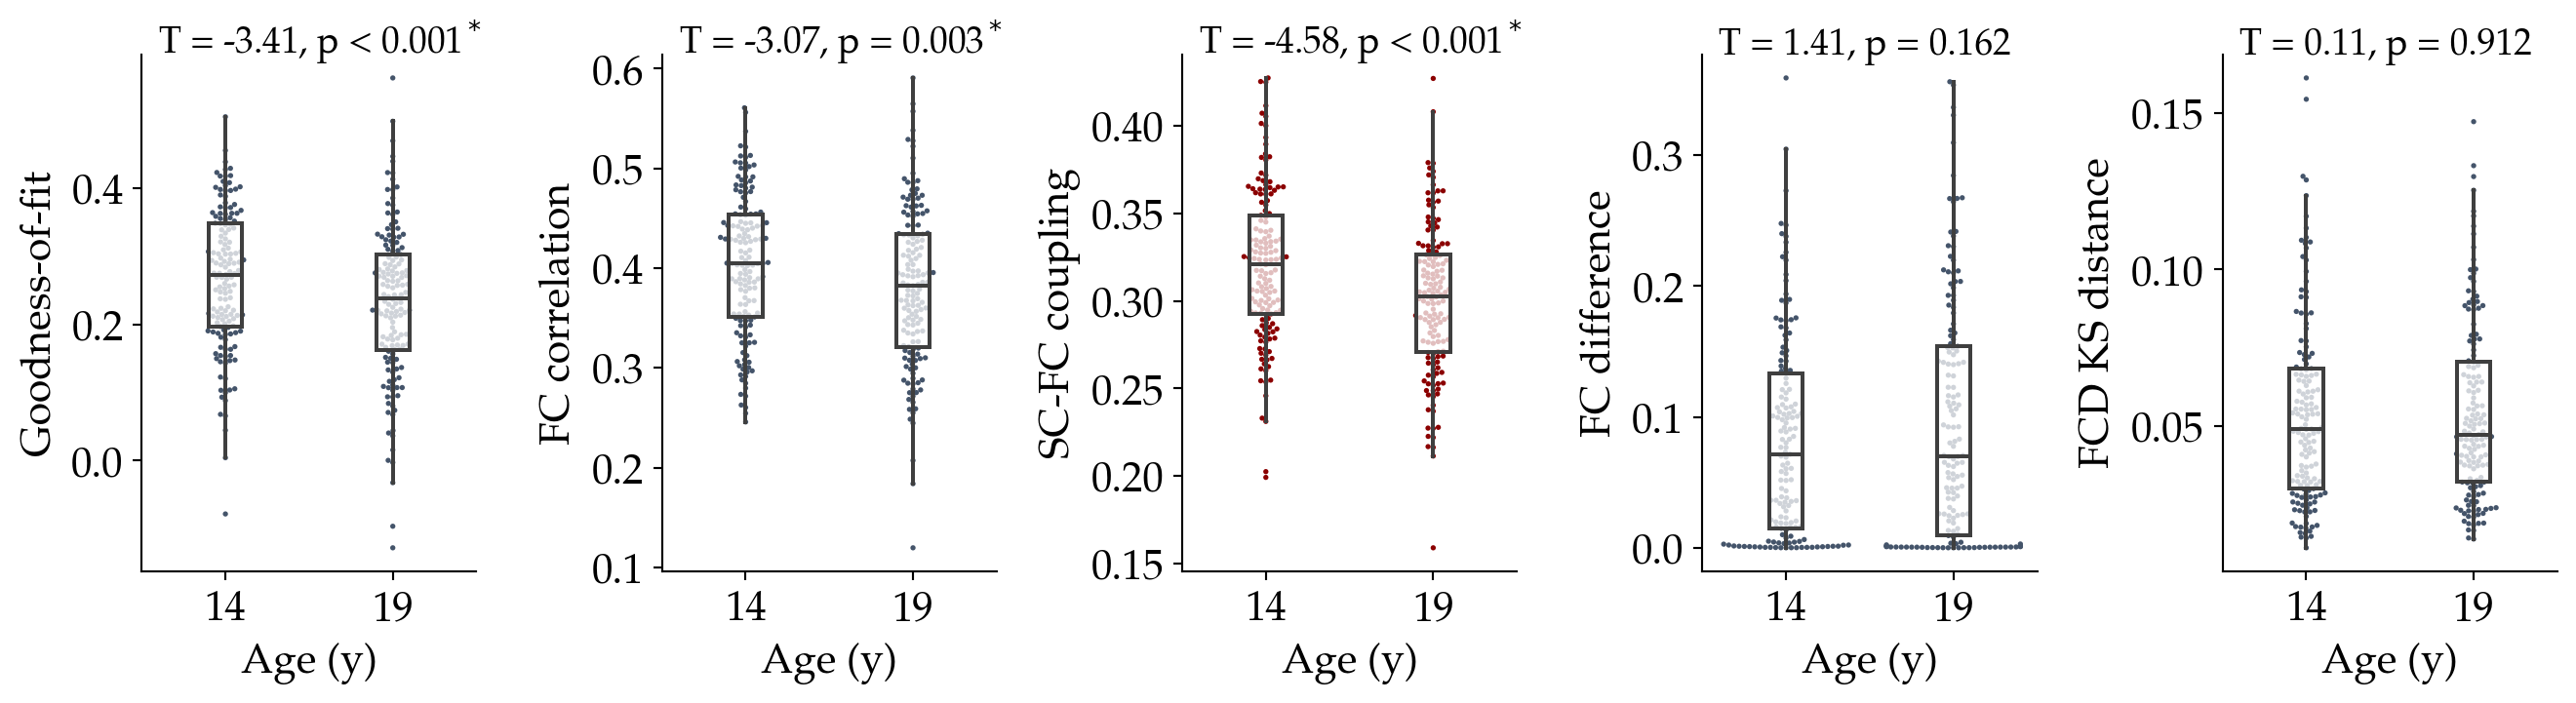

In [144]:
gof_labels = {
    "gof": "Goodness-of-fit",
    "fc_corr": "FC correlation",
    "sc_fc": "SC-FC coupling",
    "fc_diff": "FC difference",
    "fcd_ks": "FCD KS distance",
}

fig, axes = plt.subplots(1, len(gof_labels), figsize=(14, 4))
add_text = True
for i, (col, label) in enumerate(gof_labels.items()):
    ax = axes[i]
    if col != "sc_fc":
        color = thcolor
    else:
        color = "darkred"
    sns.swarmplot(data=data.reset_index(), x="ses", y=col, s=2, color=color, ax=ax)
    sns.boxplot(
        data=data.reset_index(),
        x="ses",
        y=col,
        showfliers=False,
        showcaps=False,
        width=0.2,
        boxprops={"facecolor": (1, 1, 1, 0.75)},
        ax=ax,
    )
    plt.setp(ax.collections, zorder=0, label="")  # puts swarm in the back
    ax.set_ylabel(label)
    ax.set_xticklabels(["14", "19"])
    ax.set_xlabel("Age (y)")
    sns.despine()
    # add statistics
    t, p = scipy.stats.ttest_rel(
        data_split["FU2"].loc[:, col], data_split["BL"].loc[:, col]
    )
    if add_text:
        if p > 0.001:
            text = f"T = {t:.2f}, p = {p:.3f}"
        else:
            text = f"T = {t:.2f}, p < 0.001"
        if p < 0.05:
            text += r"$^*$"
        text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
        text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 1
        ax.text(text_x, text_y, text, color="black", size=14, multialignment="left")
    print(label, round(t, 3), round(p, 3), sep="\t")
fig.tight_layout(pad=1.0)

Descriptives:

In [142]:
data_split["BL"][list(gof_labels.keys())].describe().round(3)

,gof,fc_corr,sc_fc,fc_diff,fcd_ks
count,149.000,149.000,149.000,149.000,149.000
mean,1.266,0.403,0.320,0.083,0.054
std,0.102,0.071,0.043,0.077,0.030
min,0.922,0.246,0.199,0.000,0.011
25%,1.197,0.351,0.292,0.015,0.030
50%,1.273,0.405,0.321,0.072,0.049
75%,1.348,0.453,0.349,0.133,0.068
max,1.504,0.561,0.427,0.359,0.161


In [8]:
data_split["FU2"][list(gof_labels.keys())].describe().round(3)

,gof,fc_corr,sc_fc,fc_diff,fcd_ks
count,149.000,149.000,149.000,149.000,149.000
mean,0.231,0.381,0.300,0.096,0.054
std,0.113,0.080,0.043,0.092,0.029
min,-0.128,0.120,0.159,0.000,0.014
25%,0.163,0.321,0.271,0.009,0.032
50%,0.238,0.382,0.303,0.070,0.047
75%,0.302,0.435,0.327,0.154,0.070
max,0.561,0.591,0.427,0.356,0.147


# Figure S4. Longitudinal effect of age on excitation-inhibition balance during adolescence based on session-specific structural connectomes

Limit subjects to the subset with good quality BL tractograms:

In [27]:
elig_subs_ses = elig_subs.loc[
    np.loadtxt(os.path.join(INPUT_DIR, "imagen_subs_BLnFU2.txt"), dtype=str)
]

In [8]:
elig_subs_ses["sex"].value_counts()

M    58
F    52
Name: sex, dtype: int64

Load data:

In [24]:
if os.path.exists("imagen_fc-ses_sc-ses_runs-2.csv") & os.path.exists(
    "imagen_fc-ses_sc-ses_runs-2_vars.pkz"
):
    subjects_optima_ses = pd.read_csv("imagen_fc-ses_sc-ses_runs-2.csv", index_col=0)
    with open("imagen_fc-ses_sc-ses_runs-2_vars.pkz", "rb") as f:
        regional_vars_ses = pickle.load(f)
else:
    subjects_optima_ses = []
    regional_vars_ses = {}
    for sub in tqdm(elig_subs_ses.index):
        regional_vars_ses[sub] = {}
        for ses in ["BL", "FU2"]:
            cmaes_dir = os.path.join(
                OUTPUT_DIR["imagen"],
                ses,
                "sim",
                sub,
                f"sc-{ses}_ctx_parc-schaefer-100_mean001_thresh-1",
                "6maps_schaefer-100_zscore",
                "cmaes_multimaps_gpu",
            )
            sims_dir = cmaes_dir.replace("cmaes_multimaps_gpu", "sims_multimaps_gpu")
            sc_path = os.path.join(
                OUTPUT_DIR["imagen"],
                ses,
                "SC",
                sub,
                "ctx_parc-schaefer-100_mean001_thresh-1_desc-strength.txt",
            )
            maps_path = os.path.join(INPUT_DIR, "6maps_schaefer-100_zscore.txt")
            emp_fc_tril_path = os.path.join(
                OUTPUT_DIR["imagen"],
                ses,
                "FC",
                sub,
                "ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass-none_exc-inter_desc-FCtril.txt",
            )
            emp_fcd_tril_path = emp_fc_tril_path.replace("FCtril", "FCDtril")
            emp_fc_tril = np.loadtxt(emp_fc_tril_path)
            emp_fcd_tril = np.loadtxt(emp_fcd_tril_path)
            regional_vars_ses[sub][ses] = {}
            for SeedMW in [1, 2]:
                cmaes_res = load_cmaes(
                    cmaes_dir,
                    sims_dir,
                    params,
                    het_params,
                    maps_path,
                    emp_fc_tril,
                    emp_fcd_tril,
                    sc_path=sc_path,
                    n_vols_remove=n_vols_remove,
                    itMax=itMax,
                    lmbda=lmbda,
                    SeedMW=SeedMW,
                    dataset="imagen",
                )
                if cmaes_res:
                    cmaes_res[0]["sub"] = sub
                    cmaes_res[0]["ses"] = ses
                    cmaes_res[0]["SeedMW"] = SeedMW
                    subjects_optima_ses.append(cmaes_res[0])
                    regional_vars_ses[sub][ses][SeedMW] = cmaes_res[1]
    subjects_optima_ses = pd.DataFrame(subjects_optima_ses)
    subjects_optima_ses.to_csv("imagen_fc-ses_sc-ses_runs-2.csv")
    with open("imagen_fc-ses_sc-ses_runs-2_vars.pkz", "wb") as f:
        pickle.dump(regional_vars_ses, f)

Select the best run in each subject-session and add the demographics and motion measures to the data:

In [32]:
subjects_optima_ses[["sex", "site"]] = elig_subs_ses.loc[
    subjects_optima_ses.set_index("sub").index, ["sex", "recruitment centre"]
].values
best_runs = subjects_optima_ses.groupby(["sub", "ses"])["gof"].idxmax().values
data_ses = subjects_optima_ses.loc[best_runs]
data_ses.loc[data_ses["ses"] == "BL", "age"] = elig_subs_ses.loc[
    data_ses.loc[data_ses["ses"] == "BL", "sub"].values, "age_BL"
].values
data_ses.loc[data_ses["ses"] == "FU2", "age"] = elig_subs_ses.loc[
    data_ses.loc[data_ses["ses"] == "FU2", "sub"].values, "age_FU2"
].values
data_ses = data_ses.set_index(["sub", "ses"])

# add motion data
motion = pd.concat([motion_BL, motion_FU2]).rename(columns={"participant_label": "sub"})
motion_ses = motion.set_index(["sub", "ses"]).loc[data_ses.index]
data_ses = pd.concat([data_ses, motion_ses], axis=1)

Create a dataframe of regional $\langle I^E \rangle$ in each subject:

In [34]:
I_E_ses = pd.DataFrame(index=data_ses.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for idx, row in data_ses.iterrows():
        sub = idx[0]
        ses = idx[1]
        I_E_ses.loc[idx, parc] = regional_vars_ses[sub][ses][row["SeedMW"]].loc[i, "I_E"]

Apply the linear mixed effects model:

In [51]:
df_ses = pd.concat([I_E_ses, data_ses], axis=1)
df_ses.columns = [f"node_{i}" for i in range(100)] + list(df_ses.columns[100:])

t_age_ses = pd.Series(index=parcels)
p_age_ses = pd.Series(index=parcels)
for i, parc in tqdm(enumerate(parcels)):
    # exclude outliers
    curr_subs_BL = (
        I_E_ses.loc[(slice(None), ["BL"]), parc]
        .loc[~(scipy.stats.zscore(I_E_ses.loc[(slice(None), ["BL"]), parc]).abs() >= 3)]
        .index.get_level_values(0)
    )
    curr_subs_FU2 = (
        I_E_ses.loc[(slice(None), ["FU2"]), parc]
        .loc[
            ~(scipy.stats.zscore(I_E_ses.loc[(slice(None), ["FU2"]), parc]).abs() >= 3)
        ]
        .index.get_level_values(0)
    )
    curr_subs = curr_subs_BL.intersection(curr_subs_FU2)
    model_df = df_ses.loc[(curr_subs, slice(None))].reset_index(drop=False)
    # fit the model
    mod = smf.mixedlm(
        f"node_{i} ~ age + gof + sex + mean_rms + site",
        data=model_df,
        groups=model_df["sub"],
    )
    res = mod.fit()
    t_age_ses.loc[parc] = res.tvalues["age"]
    p_age_ses.loc[parc] = res.pvalues["age"]

# FDR correction
_, p_age_fdr_ses = statsmodels.stats.multitest.fdrcorrection(p_age_ses)
p_age_fdr_ses = pd.Series(p_age_fdr_ses, index=parcels)

# display stats of signficant regions
stats_age_ses = pd.DataFrame({"t": t_age_ses, "p": p_age_ses, "p_fdr": p_age_fdr_ses})
stats_age_ses[stats_age_ses["p_fdr"] < 0.05].sort_values(by="t").round(3)

100it [00:16,  6.20it/s]


,t,p,p_fdr
7Networks_RH_Default_PFCdPFCm_2,-6.558,0.0,0.0
7Networks_RH_Cont_PFCl_3,-6.043,0.0,0.0
7Networks_RH_Cont_Par_2,-5.992,0.0,0.0
7Networks_RH_Cont_Par_1,-5.879,0.0,0.0
7Networks_LH_Cont_Par_1,-5.706,0.0,0.0
...,...,...,...
7Networks_RH_Vis_2,4.422,0.0,0.0
7Networks_RH_SalVentAttn_FrOperIns_1,4.499,0.0,0.0
7Networks_RH_SomMot_2,5.386,0.0,0.0
7Networks_LH_SomMot_2,5.438,0.0,0.0


In [154]:
stats_age_ses.to_csv("p_imagen_fc-ses_sc-ses_runs-2_IE_age_stats.csv")

## a. Effect of age on $\langle I_i^E \rangle$ (FDR-corrected)

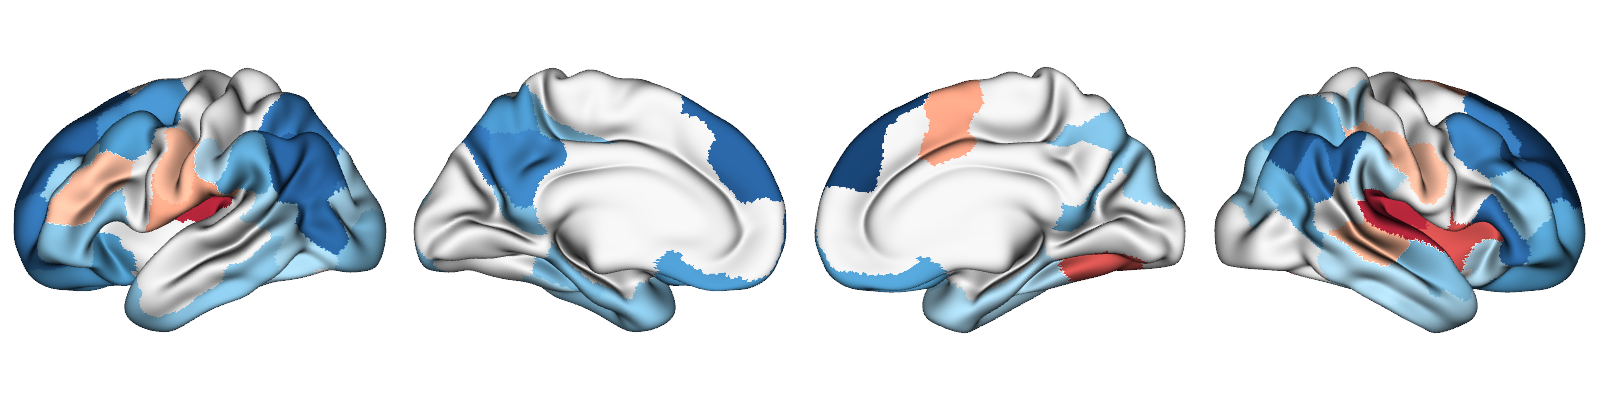

In [54]:
plot.plot_surface(
    transform.deparcellate_surf(
        t_age_ses[p_age_fdr_ses < 0.05], "schaefer-100", concat=True, space="fsaverage"
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu_r",
    cbar=False,
    layout_style="row",
)

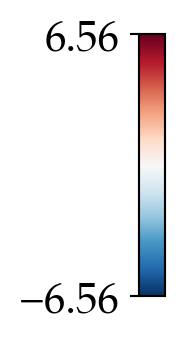

In [156]:
vmin = min(t_age_ses.values.min(), -t_age_ses.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), "RdBu_r", figsize=(2, 2));

## b. Effect of age on $\langle I_i^E \rangle$ (unthresholded)

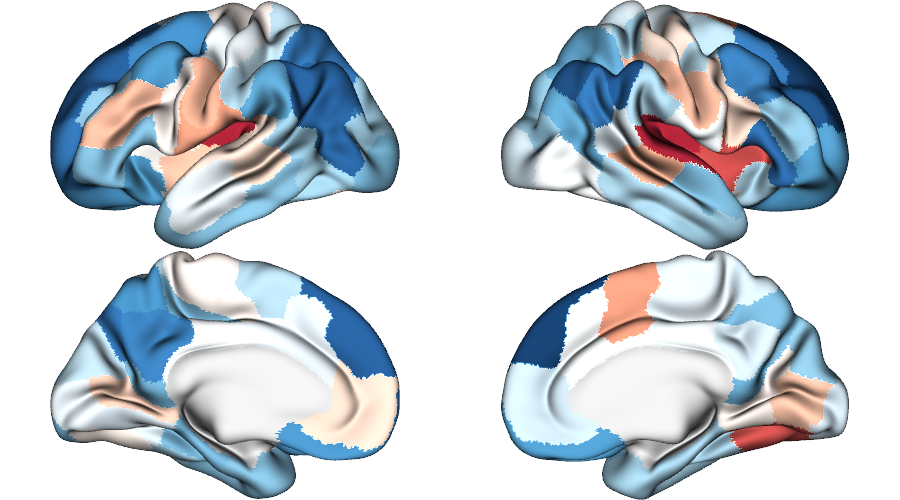

In [157]:
plot.plot_surface(
    transform.deparcellate_surf(
        t_age_ses, "schaefer-100", concat=True, space="fsaverage"
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu_r",
    cbar=False,
    layout_style="grid",
)

## c. Correlation with $\langle I_i^E \rangle$ age effects using FU2 SC

In [52]:
r_aget_ses, p_aget_ses, _ = stats.spin_test_parcellated(
    t_age.to_frame(), t_age_ses.to_frame(), "schaefer-100", n_perm=1000
)
print("Correlation coefficients\n", r_aget_ses, "\nSpin p-values\n", p_aget_ses)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficients
           0
0  0.779145 
Spin p-values
      0
0  0.0


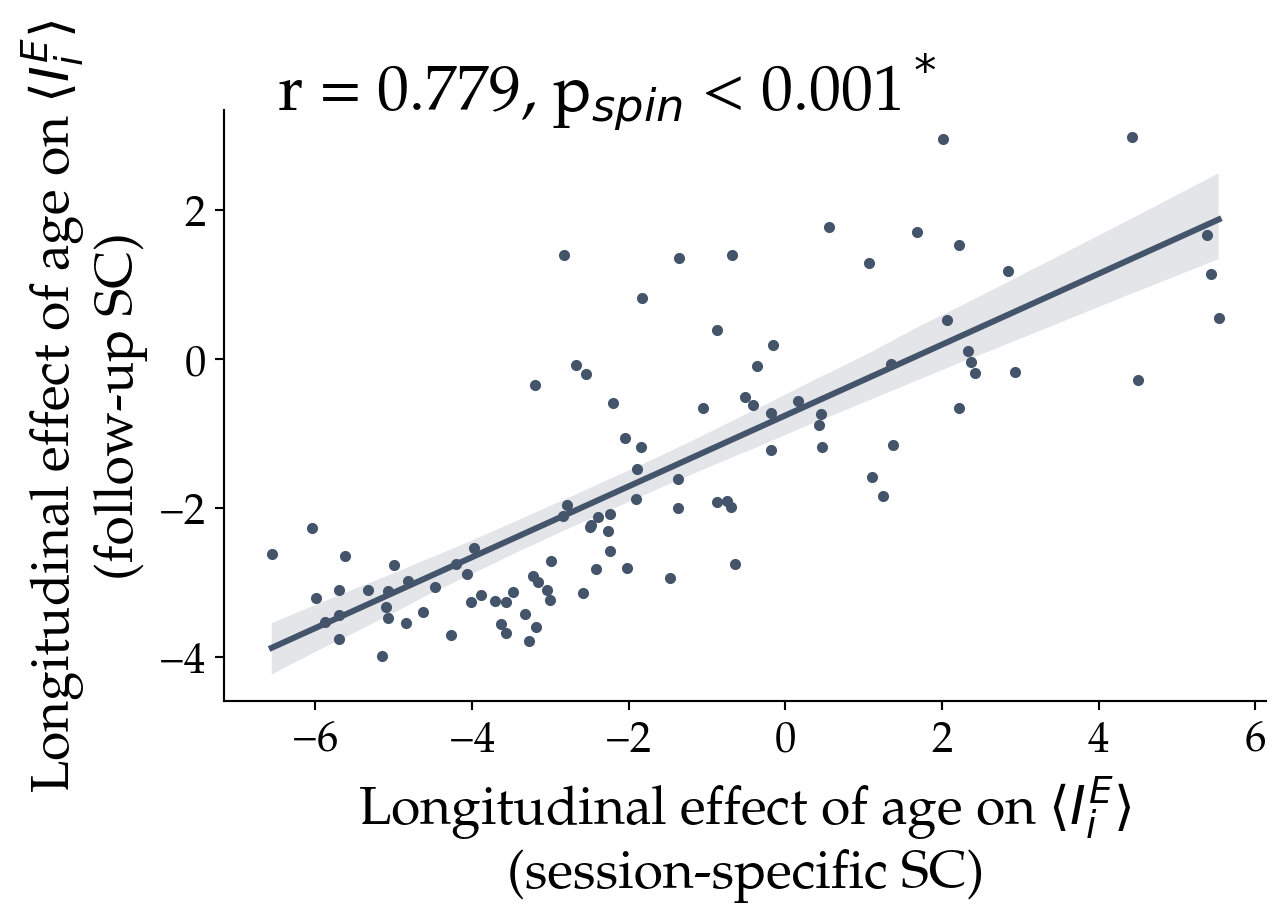

In [55]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.regplot(
    x=t_age_ses,
    y=t_age,
    scatter_kws=dict(color=thcolor, alpha=1, s=10),
    line_kws=dict(color=thcolor),
    ax=ax,
)
r = r_aget_ses.values[0, 0]
p = p_aget_ses.values[0, 0]
if p > 0.001:
    text = f"r = {r:.3f}, p = {p:.3f}"
else:
    text = f"r = {r:.3f}, p < 0.001"
if p < 0.05:
    text += r"$^*$"
text = text.replace("p", r"p$_{spin}$")
text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 1
ax.text(text_x, text_y, text, color="black", size=24, multialignment="left")
ax.set_xlabel(
    r"Longitudinal effect of age on $\langle I_i^E \rangle$" "\n(session-specific SC)",
    fontdict=dict(fontsize=20),
)
ax.set_ylabel(
    r"Longitudinal effect of age on $\langle I_i^E \rangle$" "\n(follow-up SC)",
    fontdict=dict(fontsize=20),
)
sns.despine()

# Figure S5. Effect of age on $\langle I_i^E \rangle$ across the conjunction mask of significant age effects across datasets

Calculate the age effect in IMAGEN:

In [56]:
df_imagen = pd.concat([I_E, data], axis=1)
# calculate average
df_imagen["conj_I_E"] = df_imagen.loc[:, conj[conj].index].mean(axis=1)
# exclude outliers
curr_subs_BL = (
    df_imagen.loc[(slice(None), ["BL"]), "conj_I_E"]
    .loc[
        ~(
            scipy.stats.zscore(df_imagen.loc[(slice(None), ["BL"]), "conj_I_E"]).abs()
            >= 3
        )
    ]
    .index.get_level_values(0)
)
curr_subs_FU2 = (
    df_imagen.loc[(slice(None), ["FU2"]), "conj_I_E"]
    .loc[
        ~(
            scipy.stats.zscore(df_imagen.loc[(slice(None), ["FU2"]), "conj_I_E"]).abs()
            >= 3
        )
    ]
    .index.get_level_values(0)
)
curr_subs = curr_subs_BL.intersection(curr_subs_FU2)
model_df = df_imagen.loc[(curr_subs, slice(None))].reset_index(drop=False)
# calculate standardized mean difference of I_E resid as a variant of Cohen's d
res_conf = smf.mixedlm(
    f"conj_I_E ~ gof + sex + mean_rms + site", data=model_df, groups=model_df["sub"]
).fit()
model_df["resid"] = res_conf.resid
resid_diff = (
    model_df.loc[model_df["ses"] == "FU2", "resid"].values
    - model_df.loc[model_df["ses"] == "BL", "resid"].values
)
d_age_conj = resid_diff.mean() / resid_diff.std(ddof=1)
# fit the main model
mod = smf.mixedlm(
    f"conj_I_E ~ age + gof + sex + mean_rms + site",
    data=model_df,
    groups=model_df["sub"],
)
res = mod.fit()
print("Cohen's d:", d_age_conj)
print(res.summary())

Cohen's d: -0.3123700450459912
           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  conj_I_E 
No. Observations:    296      Method:              REML     
No. Groups:          148      Scale:               0.0000   
Min. group size:     2        Log-Likelihood:      1523.8140
Max. group size:     2        Converged:           Yes      
Mean group size:     2.0                                    
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         0.381    0.001 656.482 0.000  0.380  0.382
sex[T.M]         -0.000    0.000  -1.742 0.082 -0.001  0.000
site[T.Dublin]    0.000    0.001   0.103 0.918 -0.001  0.001
site[T.London]   -0.001    0.000  -2.346 0.019 -0.001 -0.000
site[T.Mannheim] -0.000    0.000  -1.864 0.062 -0.001  0.000
site[T.Paris]    -0.000    0.000  -2.217 0.027 -0.001 -0.000
age  

In [57]:
# for plotting
model_df_imagen = model_df
res_imagen = res

Load PNC data and calculate age effect:

In [58]:
parcels = transform.load_ordered_parcel_labels("schaefer-100")
elig_subs_pnc = pd.read_csv(
    os.path.join(INPUT_DIR, "pnc_subs.csv"), index_col=0
).sort_index()

if os.path.exists("pnc_fc-sub_sc-sub_runs-2.csv") & os.path.exists(
    "pnc_fc-sub_sc-sub_runs-2_vars.pkz"
):
    subjects_optima_pnc = pd.read_csv("pnc_fc-sub_sc-sub_runs-2.csv", index_col=0)
    with open("pnc_fc-sub_sc-sub_runs-2_vars.pkz", "rb") as f:
        regional_vars_pnc = pickle.load(f)
else:
    print("Run Figure 2 notebook first")

best_runs = subjects_optima_pnc.groupby("sub")["gof"].idxmax().values
data_pnc = subjects_optima_pnc.loc[best_runs].set_index("sub")
data_pnc["gof"] += 1
data_pnc[["age", "sex", "group"]] = elig_subs_pnc.loc[
    data_pnc.index, ["age", "sex", "group"]
]
data_pnc["Age (y)"] = data_pnc["age"] / 12

# add motion data
motion_pnc = pd.read_csv(
    os.path.join(OUTPUT_DIR["pnc"], "postfmriprep", "participants.tsv"),
    delimiter="\t",
    index_col=0,
).loc[data_pnc.index]
data_pnc = pd.concat([data_pnc, motion_pnc], axis=1)

I_E_pnc = pd.DataFrame(index=data_pnc.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for sub, row in data_pnc.iterrows():
        I_E_pnc.loc[sub, parc] = regional_vars_pnc[sub][row["SeedMW"]].loc[i, "I_E"]

df_pnc = pd.concat([I_E_pnc, data_pnc], axis=1)

In [59]:
# calculate average
df_pnc["conj_I_E"] = df_pnc.loc[:, conj[conj].index].mean(axis=1)
# exclude outliers
curr_subs = df_pnc.index[(scipy.stats.zscore(df_pnc.loc[:, "conj_I_E"]).abs() < 3)]
model_df = df_pnc.loc[curr_subs]
# fit the confound removal model to calculate pearson's r of the
# residual of I_E with age as an easy-to-interpret effect size
res_conf = smf.ols(f"conj_I_E ~ gof + sex + mean_rms", data=model_df).fit()
model_df["resid"] = res_conf.resid
r_age = scipy.stats.pearsonr(model_df["age"], model_df["resid"]).statistic
# fit the main model
mod = smf.ols(f"conj_I_E ~ age + gof + sex + mean_rms", data=model_df)
res = mod.fit()
print("Pearson's r", r_age)
print(res.summary())

Pearson's r -0.23222033701651795
                            OLS Regression Results                            
Dep. Variable:               conj_I_E   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     20.70
Date:                Fri, 03 May 2024   Prob (F-statistic):           3.45e-16
Time:                        13:49:40   Log-Likelihood:                 3898.6
No. Observations:                 746   AIC:                            -7787.
Df Residuals:                     741   BIC:                            -7764.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.37

In [60]:
# for plotting
model_df_pnc = model_df
res_pnc = res

Plot:

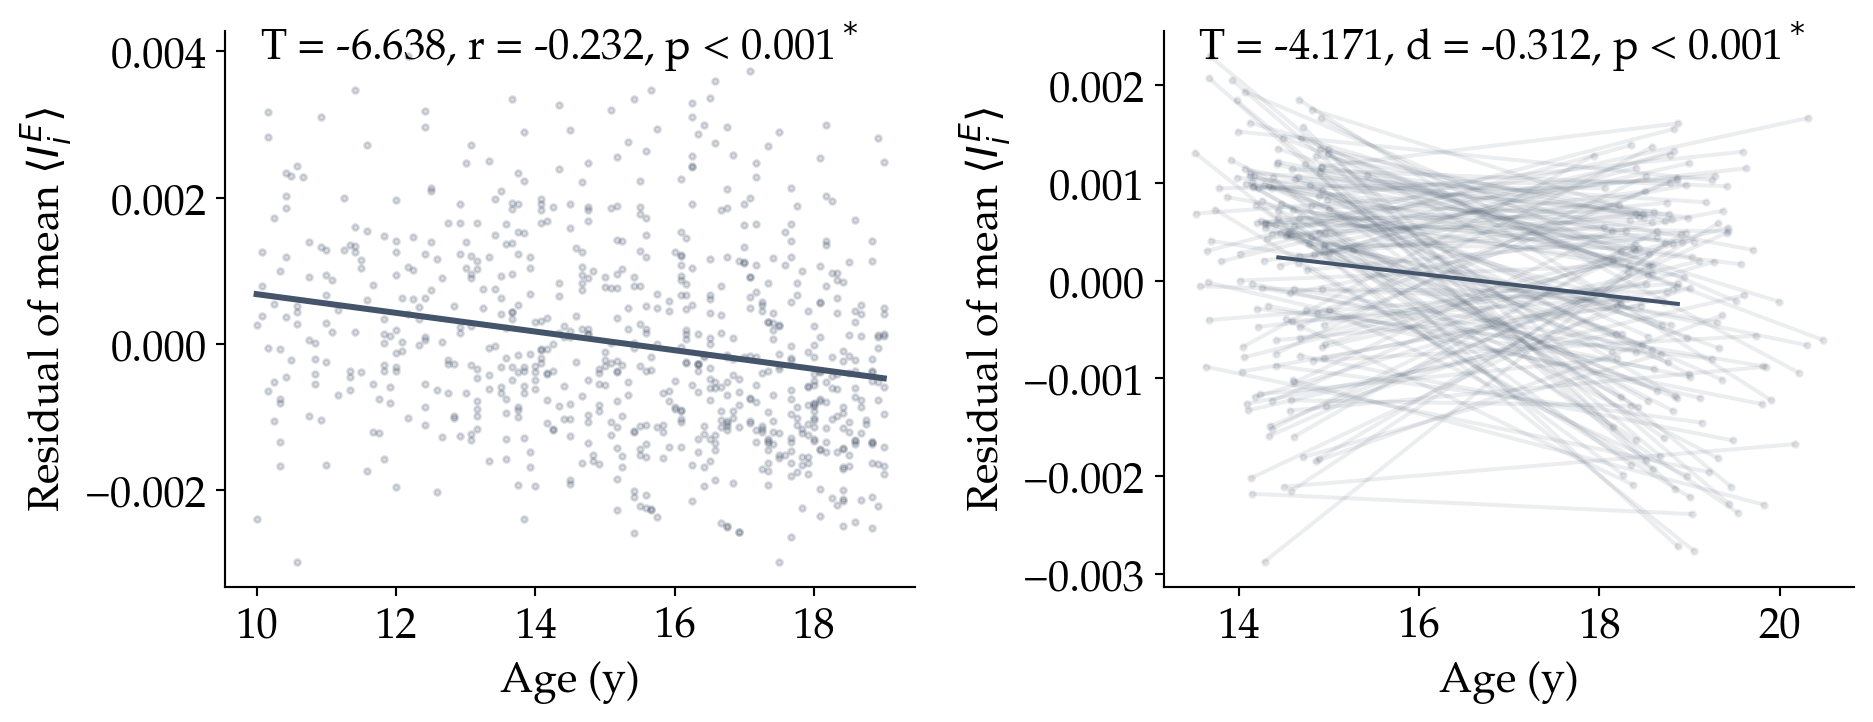

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
add_text = True

# pnc
ax = axes[0]
sns.regplot(
    model_df_pnc["Age (y)"],
    model_df_pnc["resid"],
    ax=ax,
    ci=None,
    scatter_kws=dict(color=thcolor, alpha=0.2, s=5),
    line_kws=dict(color=thcolor, alpha=1.0),
)
p = res_pnc.pvalues["age"]
t = res_pnc.tvalues["age"]
if add_text:
    text = f"T = {t:.3f}, r = {r_age:.3f}"
    if p > 0.001:
        text += f", p = {p:.3f}"
    else:
        text += f", p < 0.001"
    if p < 0.05:
        text += r"$^*$"
    text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
    text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
    ax.text(text_x, text_y, text, color="black", size=16, multialignment="left")
ax.set_ylabel(r"Residual of mean $\langle I_i^E \rangle$")
ax.set_xlabel("Age (y)")
sns.despine()

# imagen
ax = axes[1]
ax.scatter(
    model_df_imagen["age"], model_df_imagen["resid"], color=thcolor, s=5, alpha=0.1
)
# plot lines for each subject
## determine color of line
for sub in model_df_imagen["sub"].unique():
    sub_df = model_df_imagen.loc[model_df_imagen["sub"] == sub]
    ax.plot(
        sub_df["age"],
        sub_df["resid"],
        color=thcolor,
        alpha=0.1,
    )
# plot the mean line of all subjects
ax.plot(
    model_df_imagen.groupby("ses")["age"].mean(),
    model_df_imagen.groupby("ses")["resid"].mean(),
    color=thcolor,
    alpha=1.0,
)
p = res_imagen.pvalues["age"]
t = res_imagen.tvalues["age"]
if add_text:
    text = f"T = {t:.3f}, d = {d_age_conj:.3f}"
    if p > 0.001:
        text += f", p = {p:.3f}"
    else:
        text += f", p < 0.001"
    if p < 0.05:
        text += r"$^*$"
    text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
    text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
    ax.text(text_x, text_y, text, color="black", size=16, multialignment="left")
ax.set_ylabel(r"Residual of mean $\langle I_i^E \rangle$")
ax.set_xlabel("Age (y)")
sns.despine()
fig.tight_layout(pad=1.0)